In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model, get_config, pull
import matplotlib.pyplot as plt
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [2]:
def run(patient, window, horizon):
    print(patient,window,horizon)
    

    train_parameters = {
        'ohio_no': patient,
        'scope': 'train',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }

    unseen_data_parameters = {
        'ohio_no': patient,
        'scope': 'test',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }
    
    source_df = create_tsfresh_dataframe(train_parameters)
    clean_df = source_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    print(clean_df.columns)
    
    regressor = setup(clean_df,
        target='label',
        feature_selection=True,
        ignore_low_variance=True,  
        html=False,
        silent=True,
        verbose=False,
        session_id=1974
        )
    print(get_config('prep_pipe'))
    print(get_config('X').columns)
    
    best3 = compare_models(
        exclude=['catboost', 'xgboost', 'et', 'rf', 'ada', 'gbr'],
        sort='RMSE',
        n_select=3,
        verbose=True
    )
    comparison_df = pull()
    display(comparison_df)
    
    
    output = {}
    output['patient'] = patient
    output['window']  = f'{window}({(window*5)} minutes)'
    output['horizon']  = f'{horizon}({(horizon*5)} minutes)'
    model = create_model(best3[0])
    first_model_df = pull()
    display(first_model_df)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    plt.show()
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    plt.show()
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
#     logger.info(output)
    
    return output
    
    
    

2021-07-12 10:49:47.742 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_6_6.pkl
2021-07-12 10:49:47.937 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


559 6 6


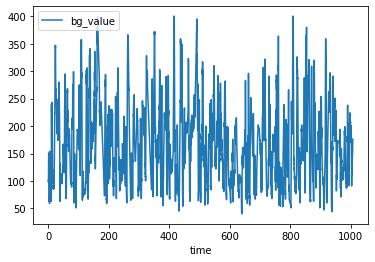

2021-07-12 10:49:48.619 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-12 10:49:48.625 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_6_6.pkl


Index(['bg_value__variance_larger_than_standard_deviation',
       'bg_value__has_duplicate_max', 'bg_value__has_duplicate_min',
       'bg_value__has_duplicate', 'bg_value__sum_values',
       'bg_value__abs_energy', 'bg_value__mean_abs_change',
       'bg_value__mean_change', 'bg_value__mean_second_derivative_central',
       'bg_value__median',
       ...
       'bg_value__permutation_entropy__dimension_6__tau_1',
       'bg_value__permutation_entropy__dimension_7__tau_1',
       'bg_value__query_similarity_count__query_None__threshold_0.0',
       'bg_value__matrix_profile__feature_"min"__threshold_0.98',
       'bg_value__matrix_profile__feature_"max"__threshold_0.98',
       'bg_value__matrix_profile__feature_"mean"__threshold_0.98',
       'bg_value__matrix_profile__feature_"median"__threshold_0.98',
       'bg_value__matrix_profile__feature_"25"__threshold_0.98',
       'bg_value__matrix_profile__feature_"75"__threshold_0.98', 'label'],
      dtype='object', length=788)
Pipelin

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,21.7753,11360.2459,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,20.5945,6701.1292,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,11360.2459,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,20.5945,6701.1292,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,11360.2459,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,970.3916,30.4207,0.8004,0.1877,0.1314,0.045
en,Elastic Net,20.5945,6701.1292,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,11360.2459,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,970.3916,30.4207,0.8004,0.1877,0.1314,0.045
br,Bayesian Ridge,20.0180,2080.8365,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6701.1292,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,11360.2459,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,10000.6345,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7721.7222,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316
huber,Huber Regressor,155.1438,7.006746e+04,221.8950,-13.0038,4.2878,0.9383,0.347
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.603
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316
huber,Huber Regressor,155.1438,7.006746e+04,221.8950,-13.0038,4.2878,0.9383,0.347
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.603
dt,Decision Tree Regressor,25.4454,1.430537e+03,37.7876,0.7097,0.2356,0.1682,0.820
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316
huber,Huber Regressor,155.1438,7.006746e+04,221.8950,-13.0038,4.2878,0.9383,0.347


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2729,7.314518e+02,27.0159,0.8515,0.1725,0.1231,1.668
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.603
dt,Decision Tree Regressor,25.4454,1.430537e+03,37.7876,0.7097,0.2356,0.1682,0.820
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2729,7.314518e+02,27.0159,0.8515,0.1725,0.1231,1.668
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.603
dt,Decision Tree Regressor,25.4454,1.430537e+03,37.7876,0.7097,0.2356,0.1682,0.820
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2729,7.314518e+02,27.0159,0.8515,0.1725,0.1231,1.668
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.045
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.603
dt,Decision Tree Regressor,25.4454,1.430537e+03,37.7876,0.7097,0.2356,0.1682,0.820
br,Bayesian Ridge,20.0180,2.080836e+03,41.0525,0.5775,0.1975,0.1355,0.227
en,Elastic Net,20.5945,6.701129e+03,55.5072,-0.3371,0.1963,0.1395,0.400
ridge,Ridge Regression,21.7753,1.136025e+04,61.3614,-1.2564,0.2085,0.1493,0.042
lasso,Lasso Regression,20.8328,1.000063e+04,61.4031,-0.9897,0.1979,0.1412,0.450
lr,Linear Regression,34.3761,7.721722e+03,69.0201,-0.5176,0.2964,0.2614,0.371
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.316


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.3134,697.3595,26.4076,0.8521,0.1729,0.1210
1,18.4029,711.6240,26.6763,0.8627,0.1659,0.1239
2,18.0523,659.0305,25.6716,0.8605,0.1696,0.1232
3,19.4271,824.4983,28.7141,0.8363,0.1765,0.1264
4,17.5557,632.0348,25.1403,0.8760,0.1588,0.1144
5,18.9503,764.3118,27.6462,0.8564,0.1751,0.1257
6,18.8300,784.1340,28.0024,0.8378,0.1827,0.1321
7,18.4381,781.0380,27.9471,0.8397,0.1778,0.1236
8,17.5308,645.0186,25.3972,0.8723,0.1680,0.1209
9,18.2280,815.4689,28.5564,0.8216,0.1777,0.1202


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.3134,697.3595,26.4076,0.8521,0.1729,0.1210
1,18.4029,711.6240,26.6763,0.8627,0.1659,0.1239
2,18.0523,659.0305,25.6716,0.8605,0.1696,0.1232
3,19.4271,824.4983,28.7141,0.8363,0.1765,0.1264
4,17.5557,632.0348,25.1403,0.8760,0.1588,0.1144
5,18.9503,764.3118,27.6462,0.8564,0.1751,0.1257
6,18.8300,784.1340,28.0024,0.8378,0.1827,0.1321
7,18.4381,781.0380,27.9471,0.8397,0.1778,0.1236
8,17.5308,645.0186,25.3972,0.8723,0.1680,0.1209
9,18.2280,815.4689,28.5564,0.8216,0.1777,0.1202


2021-07-12 10:51:41.412 | INFO     | __main__:run:58 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18.2528,719.2468,26.8188,0.8578,0.1724,0.124


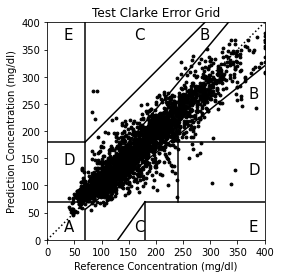

2021-07-12 10:51:42.282 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_6.pkl
2021-07-12 10:51:42.305 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


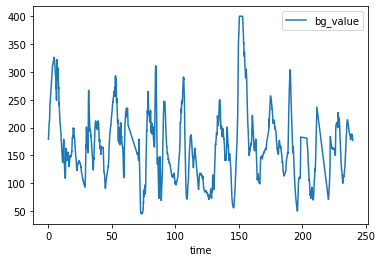

2021-07-12 10:51:42.562 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-12 10:51:42.563 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_6.pkl


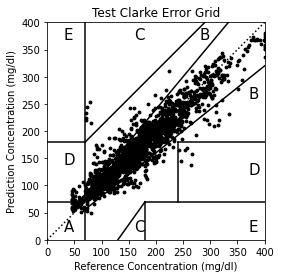

[{'patient': 559,
  'window': '6(30 minutes)',
  'horizon': '6(30 minutes)',
  'model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=1974, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
  'model_name': 'LGBMRegressor',
  'internal_cga_analysis': [2629, 502, 4, 101, 0],
  'internal_rmse': 26.818777147774703,
  'internal_rmadex': 3036.999115108755,
  'unseen_cga_analysis': [2221, 246, 6, 30, 0],
  'unseen_rmse': 22.098451894174623,
  'unseen_rmadex': 177.7933822763437}]

In [4]:
patients = [559]
windows = [6]
horizons = [6]
[run(patient,window, horizon) for patient in patients for window in windows for horizon in horizons]